**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (30, 30))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [8]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'

# output
TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

### Загрузка данных

In [9]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
df_train.shape

(7500, 17)

In [11]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [13]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [14]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Переведем признаки Tax Liens, Number of Credit Problems, Bankruptcies из количественных в категориальные поскольку они имеют малое количество вариантов значений.

In [15]:
def inttopbj(df):
    df['Tax Liens'] = df['Tax Liens'].astype('object')
    df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('object')
    df['Bankruptcies'] = df['Bankruptcies'].astype('object')
    
    return df

df_train = inttopbj(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   object 
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   object 
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   object 
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Обзор номинативных признаков**

In [16]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, d

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [17]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Видно что у признаков "Annual Income", "Years in current job", "Months since last delinquent", "Bankruptcies" и "Credit Score" есть пропущенные значения, необходимо их заполнить.


Т.к. у признака "Months since last delinquent" пропущена более чем половина значений, удалим этот признак из выборки, поскольку заполнить пропуски по нему является проблематичным.

In [18]:
def dropMsld(df):
    df = df.drop(['Months since last delinquent'], axis=1)
    return df

In [19]:
df_train = dropMsld(df_train)

Пустые значения признака "Bankruptcies" модой этого признака

In [20]:
def fillBankruptcies(df):
    df['Bankruptcies']  = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0]).astype(object)
    return df

In [21]:
df_train = fillBankruptcies(df_train)

Признак Years in current job заполним пропуски 'Years of Credit History'

In [22]:
def fillYears_job(df):
    df.loc[(df['Years of Credit History'] >= 10.0) & (df['Years in current job'].isna()), 'Years in current job'] = str('10+ years')
    df.loc[(df['Years of Credit History'] < 10) & (df['Years in current job'].isna()), 
           'Years in current job'] = (round(df['Years of Credit History'])).astype(str) + ' years'
    return df

In [23]:
df_train = fillYears_job(df_train)
df_train['Years in current job'].value_counts()

10+ years    2686
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
7.0 years       6
8.0 years       5
9.0 years       5
5.0 years       1
Name: Years in current job, dtype: int64

Теперь функции для заполнения Annual Income и Credit Score

In [24]:
def fillAnnualInc(df):
    df['Annual Income']  = df['Annual Income'].fillna(df['Annual Income'].mean())
    return df

def fillCreditScore(df):
    df['Credit Score']  = df['Credit Score'].fillna(df['Credit Score'].mean())
    return df

In [25]:
df_train = fillCreditScore(df_train)
df_train = fillAnnualInc(df_train)

### Обработка выбросов

##### Home Ownership

In [26]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = df_train['Home Ownership'].mode()[0]

##### Years in current job

In [27]:
df_train.loc[df_train['Years in current job'] == '7.0 years', 'Years in current job'] = '7 years'
df_train.loc[df_train['Years in current job'] == '8.0 years', 'Years in current job'] = '8 years'
df_train.loc[df_train['Years in current job'] == '9.0 years', 'Years in current job'] = '9 years'
df_train.loc[df_train['Years in current job'] == '5.0 years', 'Years in current job'] = '5 years'
# при заполнении этого признака не удалось избавиться от нулей ни каким способом, поэтому делаю это в обработке выбросов

##### Purpose

In [28]:
df_train.loc[df_train['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
df_train.loc[df_train['Purpose'] == 'vacation', 'Purpose'] = 'other'
df_train.loc[df_train['Purpose'] == 'educational expenses', 'Purpose'] = 'other'
df_train.loc[df_train['Purpose'] == 'moving', 'Purpose'] = 'other'
df_train.loc[df_train['Purpose'] == 'wedding', 'Purpose'] = 'other'
df_train['Purpose'].value_counts()

debt consolidation    5944
other                  711
home improvements      412
business loan          129
buy a car               96
medical bills           71
major purchase          40
take a trip             37
buy house               34
small business          26
Name: Purpose, dtype: int64

##### Tax Liens

In [29]:
df_train.loc[(df_train['Tax Liens'] == 7) | (df_train['Tax Liens'] == 6) | (df_train['Tax Liens'] == 5), 'Tax Liens'] = 4
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
4.0      11
3.0      10
Name: Tax Liens, dtype: int64

##### Number of Credit Problems

In [30]:
df_train.loc[(df_train['Number of Credit Problems'] == 7) | (df_train['Number of Credit Problems'] == 6) | 
             (df_train['Number of Credit Problems'] == 5), 'Number of Credit Problems'] = 4
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0      21
Name: Number of Credit Problems, dtype: int64

##### Bankruptcies

In [31]:
df_train.loc[df_train['Bankruptcies'] == 4, 'Bankruptcies'] = 3
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       9
Name: Bankruptcies, dtype: int64

#### С помощью violinplot просмотрим количественные признаки на выбросы:

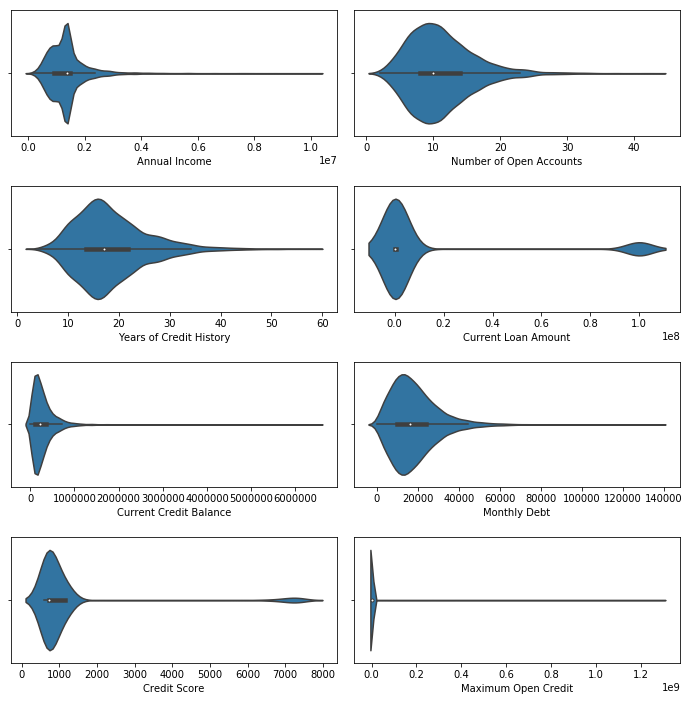

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax.flatten()

sns.violinplot(x='Annual Income', data=df_train, ax=ax1)
sns.violinplot(x='Number of Open Accounts', data=df_train, ax=ax2)
sns.violinplot(x='Years of Credit History', data=df_train, ax=ax3)
sns.violinplot(x='Current Loan Amount', data=df_train, ax=ax4)
sns.violinplot(x='Current Credit Balance', data=df_train, ax=ax5)
sns.violinplot(x='Monthly Debt', data=df_train, ax=ax6)
sns.violinplot(x='Credit Score', data=df_train, ax=ax7)
sns.violinplot(x='Maximum Open Credit', data=df_train, ax=ax8)

fig.set_size_inches(12, 12)

plt.subplots_adjust(wspace=0.05, hspace=0.4)

##### Проанализировав графики, я объеденю 2 признака - 'Annual Income' и 'Current Loan Amount' и удалю строки, которые выходят за пределы 'усов' их boxplot'ов

In [33]:
def drop_anninc_curamnt(df):
    df = df.drop(df[df['Annual Income'] > 2300000].index)
    df = df.drop(df[df["Current Loan Amount"] > 950000].index)
    return df

df_train = drop_anninc_curamnt(df_train)

###### Далее на основании графиков напишем функции для обработки выбросов по другим признакам

In [34]:
def prep_numOfAcc(df):
    df.loc[df['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = np.round(df['Number of Open Accounts'].mean())
    return df

df_train = prep_numOfAcc(df_train)

In [35]:
def years_credit_his(df):
    df.loc[df['Years of Credit History'] > 35, 'Years of Credit History'] = np.round(df['Years of Credit History'].mean())
    return df

df_train = years_credit_his(df_train)

In [36]:
def bal_debt_open(df):
    df = df.drop(df.loc[(df['Current Credit Balance'] > 750000)&(df['Monthly Debt'] > 45000)
             &(df['Maximum Open Credit'] > 1000000)].index)
    return df

df_train = bal_debt_open(df_train)

In [37]:
def month_debt(df):
    df = df.drop(df.loc[df['Monthly Debt'] > 45000, 'Monthly Debt'].index)
    return df

df_train = month_debt(df_train)

In [38]:
def cred_bal(df):
    df.loc[df['Current Credit Balance'] > 750000, 'Current Credit Balance'] = np.round(df['Current Credit Balance'].mean())
    return df

df_train = cred_bal(df_train)

In [39]:
def cred_score(df):
    df_train.loc[df_train['Credit Score'] > 6000, 'Credit Score'] = np.round(df['Credit Score'].mean())
    return df

df_train = cred_score(df_train)

In [40]:
def open_cred(df):
    df.loc[df['Maximum Open Credit'] > 1000000, 'Maximum Open Credit'] = np.round(df['Maximum Open Credit'].mean())
    return df

df_train = open_cred(df_train)

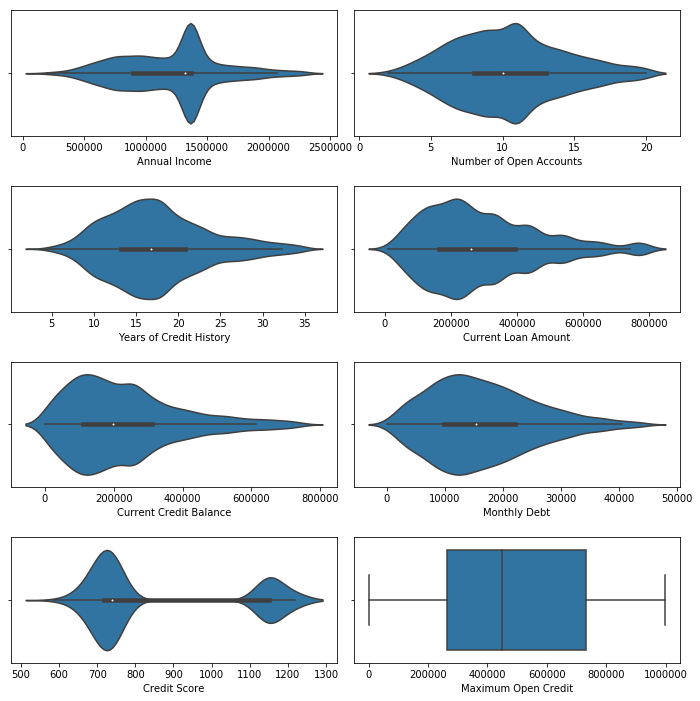

In [41]:
fig, ax = plt.subplots(nrows=4, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax.flatten()

sns.violinplot(x='Annual Income', data=df_train, ax=ax1)
sns.violinplot(x='Number of Open Accounts', data=df_train, ax=ax2)
sns.violinplot(x='Years of Credit History', data=df_train, ax=ax3)
sns.violinplot(x='Current Loan Amount', data=df_train, ax=ax4)
sns.violinplot(x='Current Credit Balance', data=df_train, ax=ax5)
sns.violinplot(x='Monthly Debt', data=df_train, ax=ax6)
sns.violinplot(x='Credit Score', data=df_train, ax=ax7)
sns.boxplot(x='Maximum Open Credit', data=df_train, ax=ax8)

fig.set_size_inches(12, 12)

plt.subplots_adjust(wspace=0.05, hspace=0.4)

### Построение новых признаков<a class="anchor" id="new_features"></a>

In [42]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

#### Credit Score

Т.к. значения признака Credit Score имеют два интервала значений, пеерведем их в значения 0 и 1, где 0 - Credit Score в интервале от 550 до 800, а 1 - Credit Score в интервале от 1000 до 1300

In [43]:
def cred_st_dm(df):
    df.loc[df['Credit Score'] < 800, 'Credit Score'] = 0
    df.loc[df['Credit Score'] > 1000, 'Credit Score'] = 1
    
    return df

df_train = cred_st_dm(df_train)

#### Id

In [44]:
df_train['Id'] = df_train.index.tolist()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6043 entries, 1 to 7499
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             6043 non-null   object 
 1   Annual Income              6043 non-null   float64
 2   Years in current job       6043 non-null   object 
 3   Tax Liens                  6043 non-null   object 
 4   Number of Open Accounts    6043 non-null   float64
 5   Years of Credit History    6043 non-null   float64
 6   Maximum Open Credit        6043 non-null   float64
 7   Number of Credit Problems  6043 non-null   object 
 8   Bankruptcies               6043 non-null   object 
 9   Purpose                    6043 non-null   object 
 10  Term                       6043 non-null   object 
 11  Current Loan Amount        6043 non-null   float64
 12  Current Credit Balance     6043 non-null   float64
 13  Monthly Debt               6043 non-null   float

#### Переведем номининативные признаки в числа и создаим dummie переменные

In [45]:
def nom_to_cat(df):
    df['Years in current job'] = df['Years in current job'].map({'10+ years':'10', '9 years':'9', '8 years':'8',
                                                                 '7 years':'7', '6 years':'6', '5 years':'5',
                                                                 '4 years':'4', '3 years':'3', '2 years':'2',
                                                                 '1 year':'1', '< 1 year':'0'}).astype(object)
    
    df['Home Ownership'] = df['Home Ownership'].map({'Home Mortgage':'1','Own Home':'2','Rent':'3'}).astype(object)
    
    df['Purpose'] = df['Purpose'].map({'debt consolidation':'1','other':'2','home improvements':'3',
                                      'business loan':'4','buy a car':'5','medical bills':'6',
                                      'major purchase':'7','take a trip':'8','buy house':'9','small business':'10'}).astype(object)
    
    df['Term'] = df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(object)
    return df

In [46]:
df_train = nom_to_cat(df_train)

In [47]:
def get_dummies(df):
    for cat_colname in df.select_dtypes(include='object').columns[1:]:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname, dtype='int64')], axis=1)
    return df

In [48]:
df_train = get_dummies(df_train)
df_train.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7,Purpose_8,Purpose_9,Term_0,Term_1
1,2,1025487.0,10,0,15.0,15.3,883755.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


#### Выделение целевой переменной и групп признаков

In [49]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Id'] + BASE_FEATURE_NAMES).tolist()

In [50]:
df_train[TARGET_NAME].value_counts()

0    4072
1    1971
Name: Credit Default, dtype: int64

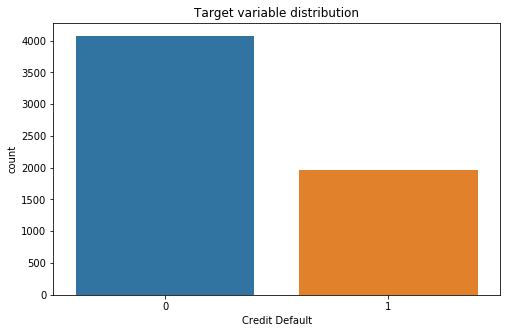

In [51]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

#### Корреляция с базовыми признаками

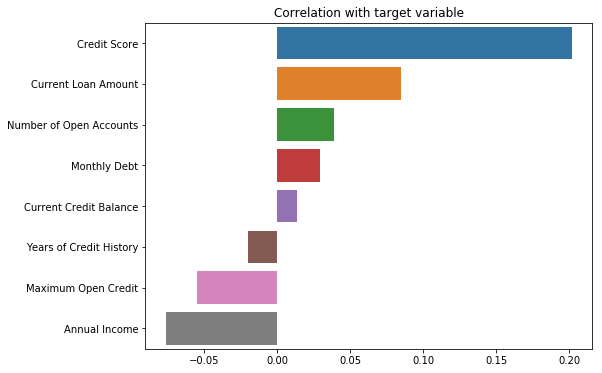

In [52]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Оценка признака "Credit Score" в разрезе целевой переменной

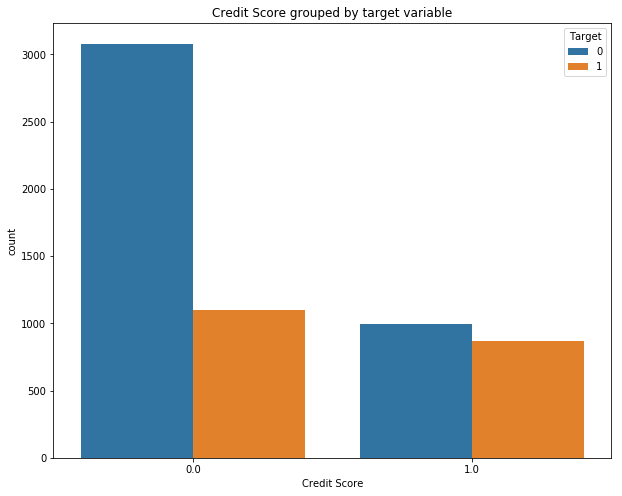

In [53]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df_train)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Из гистограммы видно, что при значении Credit score = 0, целевая переменная принимает значение 0 в гораздо большей степени ,чем при Credit Score = 1. 

In [54]:
crSc_and_target_s = df_train.loc[df_train['Credit Score'].isin([1, 0]), ['Id', 'Credit Score', 'Credit Default']].sample(1000)

In [55]:
table = crSc_and_target_s.pivot_table(values='Id', index='Credit Score', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Credit Score,,
0.0,513,174
1.0,168,145


In [56]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

3.936846254038718e-11

#### Оценка признака "Annual Income" в разрезе целевой переменной

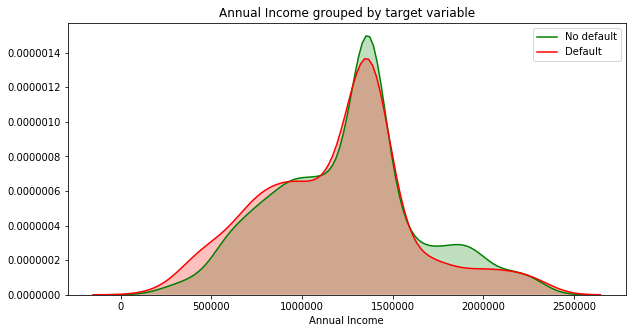

In [57]:
annual_income_with_target_s = df_train[['Annual Income', TARGET_NAME]].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Annual Income" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [58]:
shapiro(annual_income_s)

(0.9713266491889954, 3.7692787259457905e-13)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

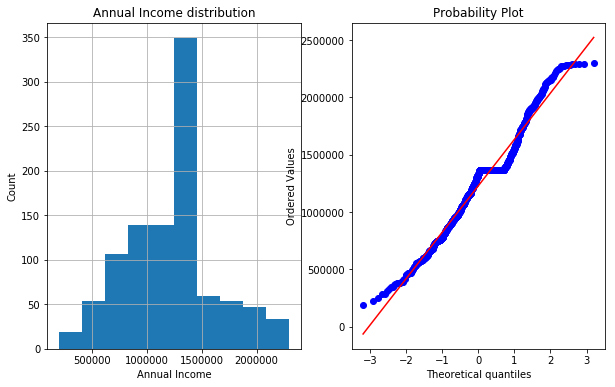

In [59]:
plt.figure(figsize=(10, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Annual Income в группах, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

In [60]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=103928.0, pvalue=0.02702803587003865)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

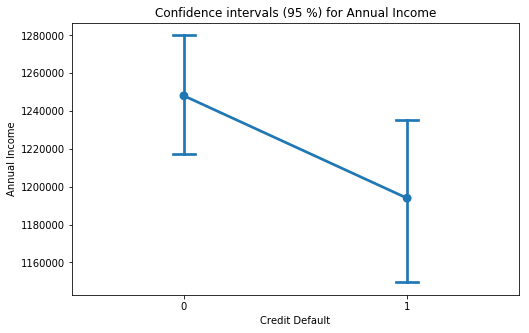

In [61]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

#### Матрица корреляций

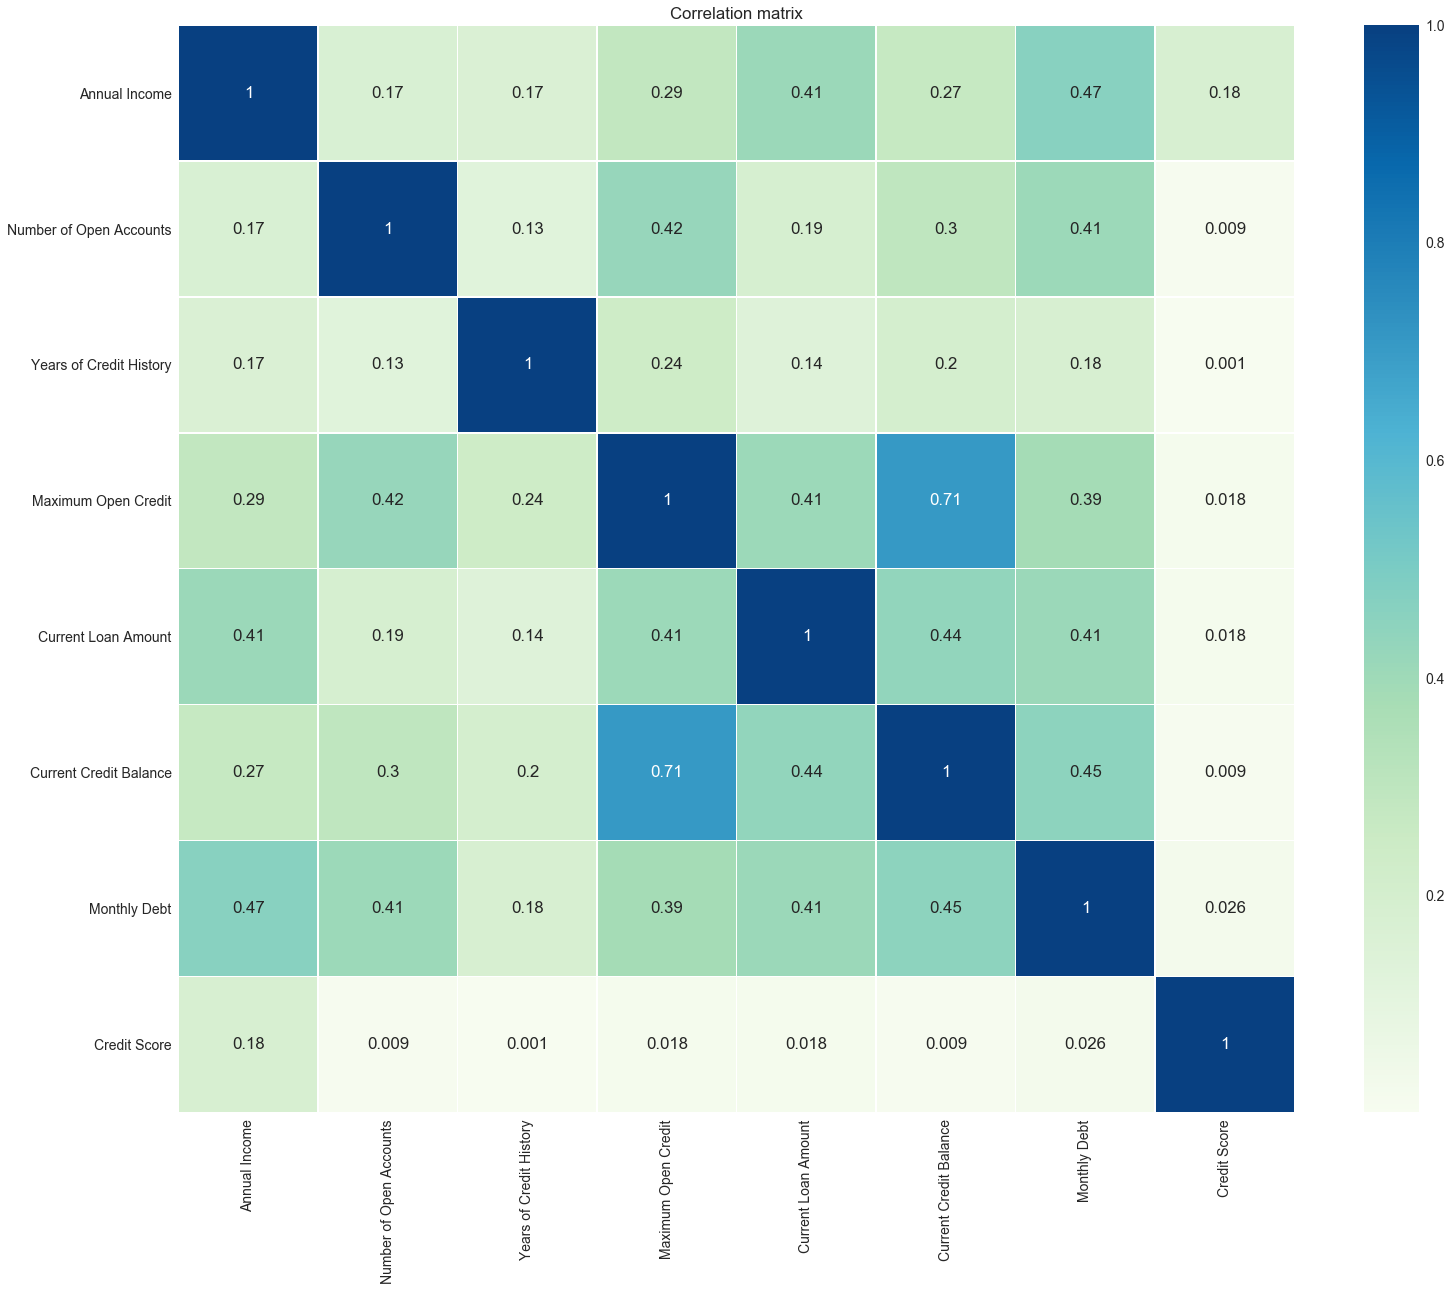

In [62]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [63]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                     'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Bankruptcies', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NEW_FEATURE_NAMES + NUM_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [64]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Tax Liens               category
Bankruptcies            category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [65]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

**Сохранение модели для нормализации данных**

In [66]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [67]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [68]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    2867
1    2726
Name: Credit Default, dtype: int64

In [69]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [70]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [71]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [72]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      2867
           1       0.61      0.58      0.60      2726

    accuracy                           0.62      5593
   macro avg       0.62      0.62      0.62      5593
weighted avg       0.62      0.62      0.62      5593

TEST

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1205
           1       0.44      0.55      0.49       608

    accuracy                           0.62      1813
   macro avg       0.59      0.60      0.59      1813
weighted avg       0.64      0.62      0.62      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               781  424
1               274  334


**k ближайших соседей**

In [73]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2867
           1       0.75      0.69      0.72      2726

    accuracy                           0.74      5593
   macro avg       0.74      0.74      0.74      5593
weighted avg       0.74      0.74      0.74      5593

TEST

              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1205
           1       0.39      0.44      0.41       608

    accuracy                           0.58      1813
   macro avg       0.54      0.55      0.54      1813
weighted avg       0.60      0.58      0.59      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               789  416
1               341  267


**Бустинговые алгоритмы**

*XGBoost*

In [74]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2867
           1       0.97      0.97      0.97      2726

    accuracy                           0.97      5593
   macro avg       0.97      0.97      0.97      5593
weighted avg       0.97      0.97      0.97      5593

TEST

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1205
           1       0.44      0.39      0.42       608

    accuracy                           0.63      1813
   macro avg       0.57      0.57      0.57      1813
weighted avg       0.62      0.63      0.62      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               898  307
1               368  240


*LightGBM*

In [75]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2867
           1       0.90      0.90      0.90      2726

    accuracy                           0.90      5593
   macro avg       0.90      0.90      0.90      5593
weighted avg       0.90      0.90      0.90      5593

TEST

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1205
           1       0.45      0.46      0.45       608

    accuracy                           0.63      1813
   macro avg       0.59      0.59      0.59      1813
weighted avg       0.63      0.63      0.63      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               871  334
1               331  277


*CatBoost*

In [76]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2867
           1       0.86      0.85      0.85      2726

    accuracy                           0.86      5593
   macro avg       0.86      0.86      0.86      5593
weighted avg       0.86      0.86      0.86      5593

TEST

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1205
           1       0.47      0.45      0.46       608

    accuracy                           0.65      1813
   macro avg       0.60      0.60      0.60      1813
weighted avg       0.64      0.65      0.65      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               900  305
1               333  275


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [77]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 2], silent=True, random_state=21)

**Подбор гиперпараметров**

In [78]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [79]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [80]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 1min 10s


In [81]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 3}

In [82]:
rs.best_score_

0.48743131793016853

**Обучение и оценка финальной модели**

In [83]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2867
           1       0.70      0.67      0.69      2726

    accuracy                           0.70      5593
   macro avg       0.70      0.70      0.70      5593
weighted avg       0.70      0.70      0.70      5593

TEST

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1205
           1       0.45      0.52      0.48       608

    accuracy                           0.63      1813
   macro avg       0.60      0.60      0.60      1813
weighted avg       0.64      0.63      0.64      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               828  377
1               294  314
Wall time: 1.38 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [84]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2867
           1       0.70      0.67      0.69      2726

    accuracy                           0.70      5593
   macro avg       0.70      0.70      0.70      5593
weighted avg       0.70      0.70      0.70      5593

TEST

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1205
           1       0.45      0.52      0.48       608

    accuracy                           0.63      1813
   macro avg       0.60      0.60      0.60      1813
weighted avg       0.64      0.63      0.64      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               828  377
1               294  314


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [85]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      class_weights=[1, 2],
                                      silent=True, random_state=21)

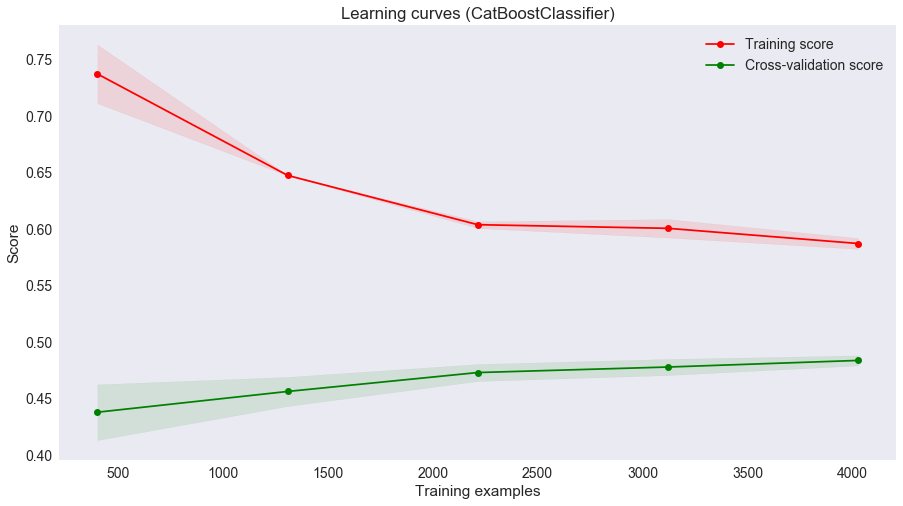

In [86]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

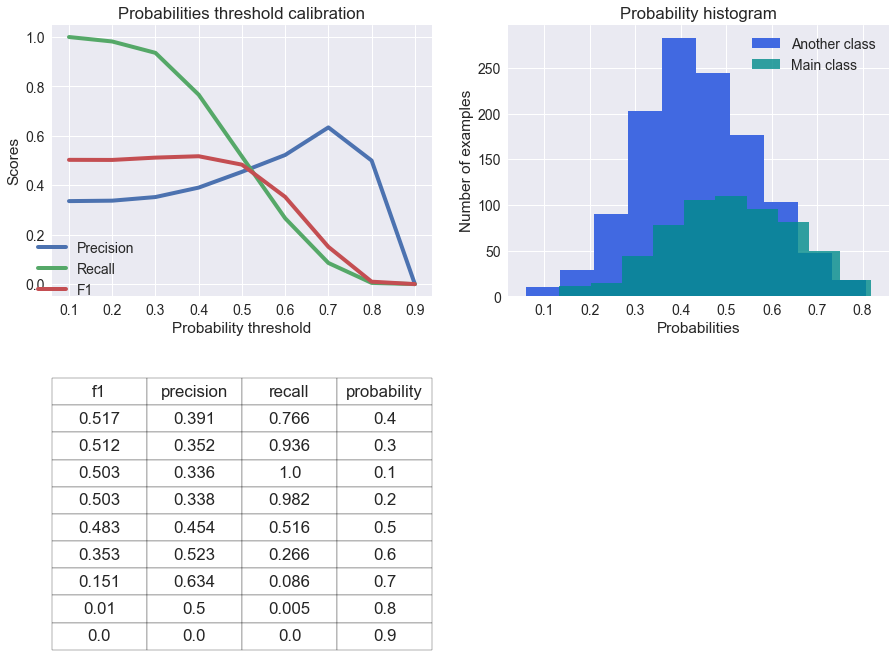

In [87]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

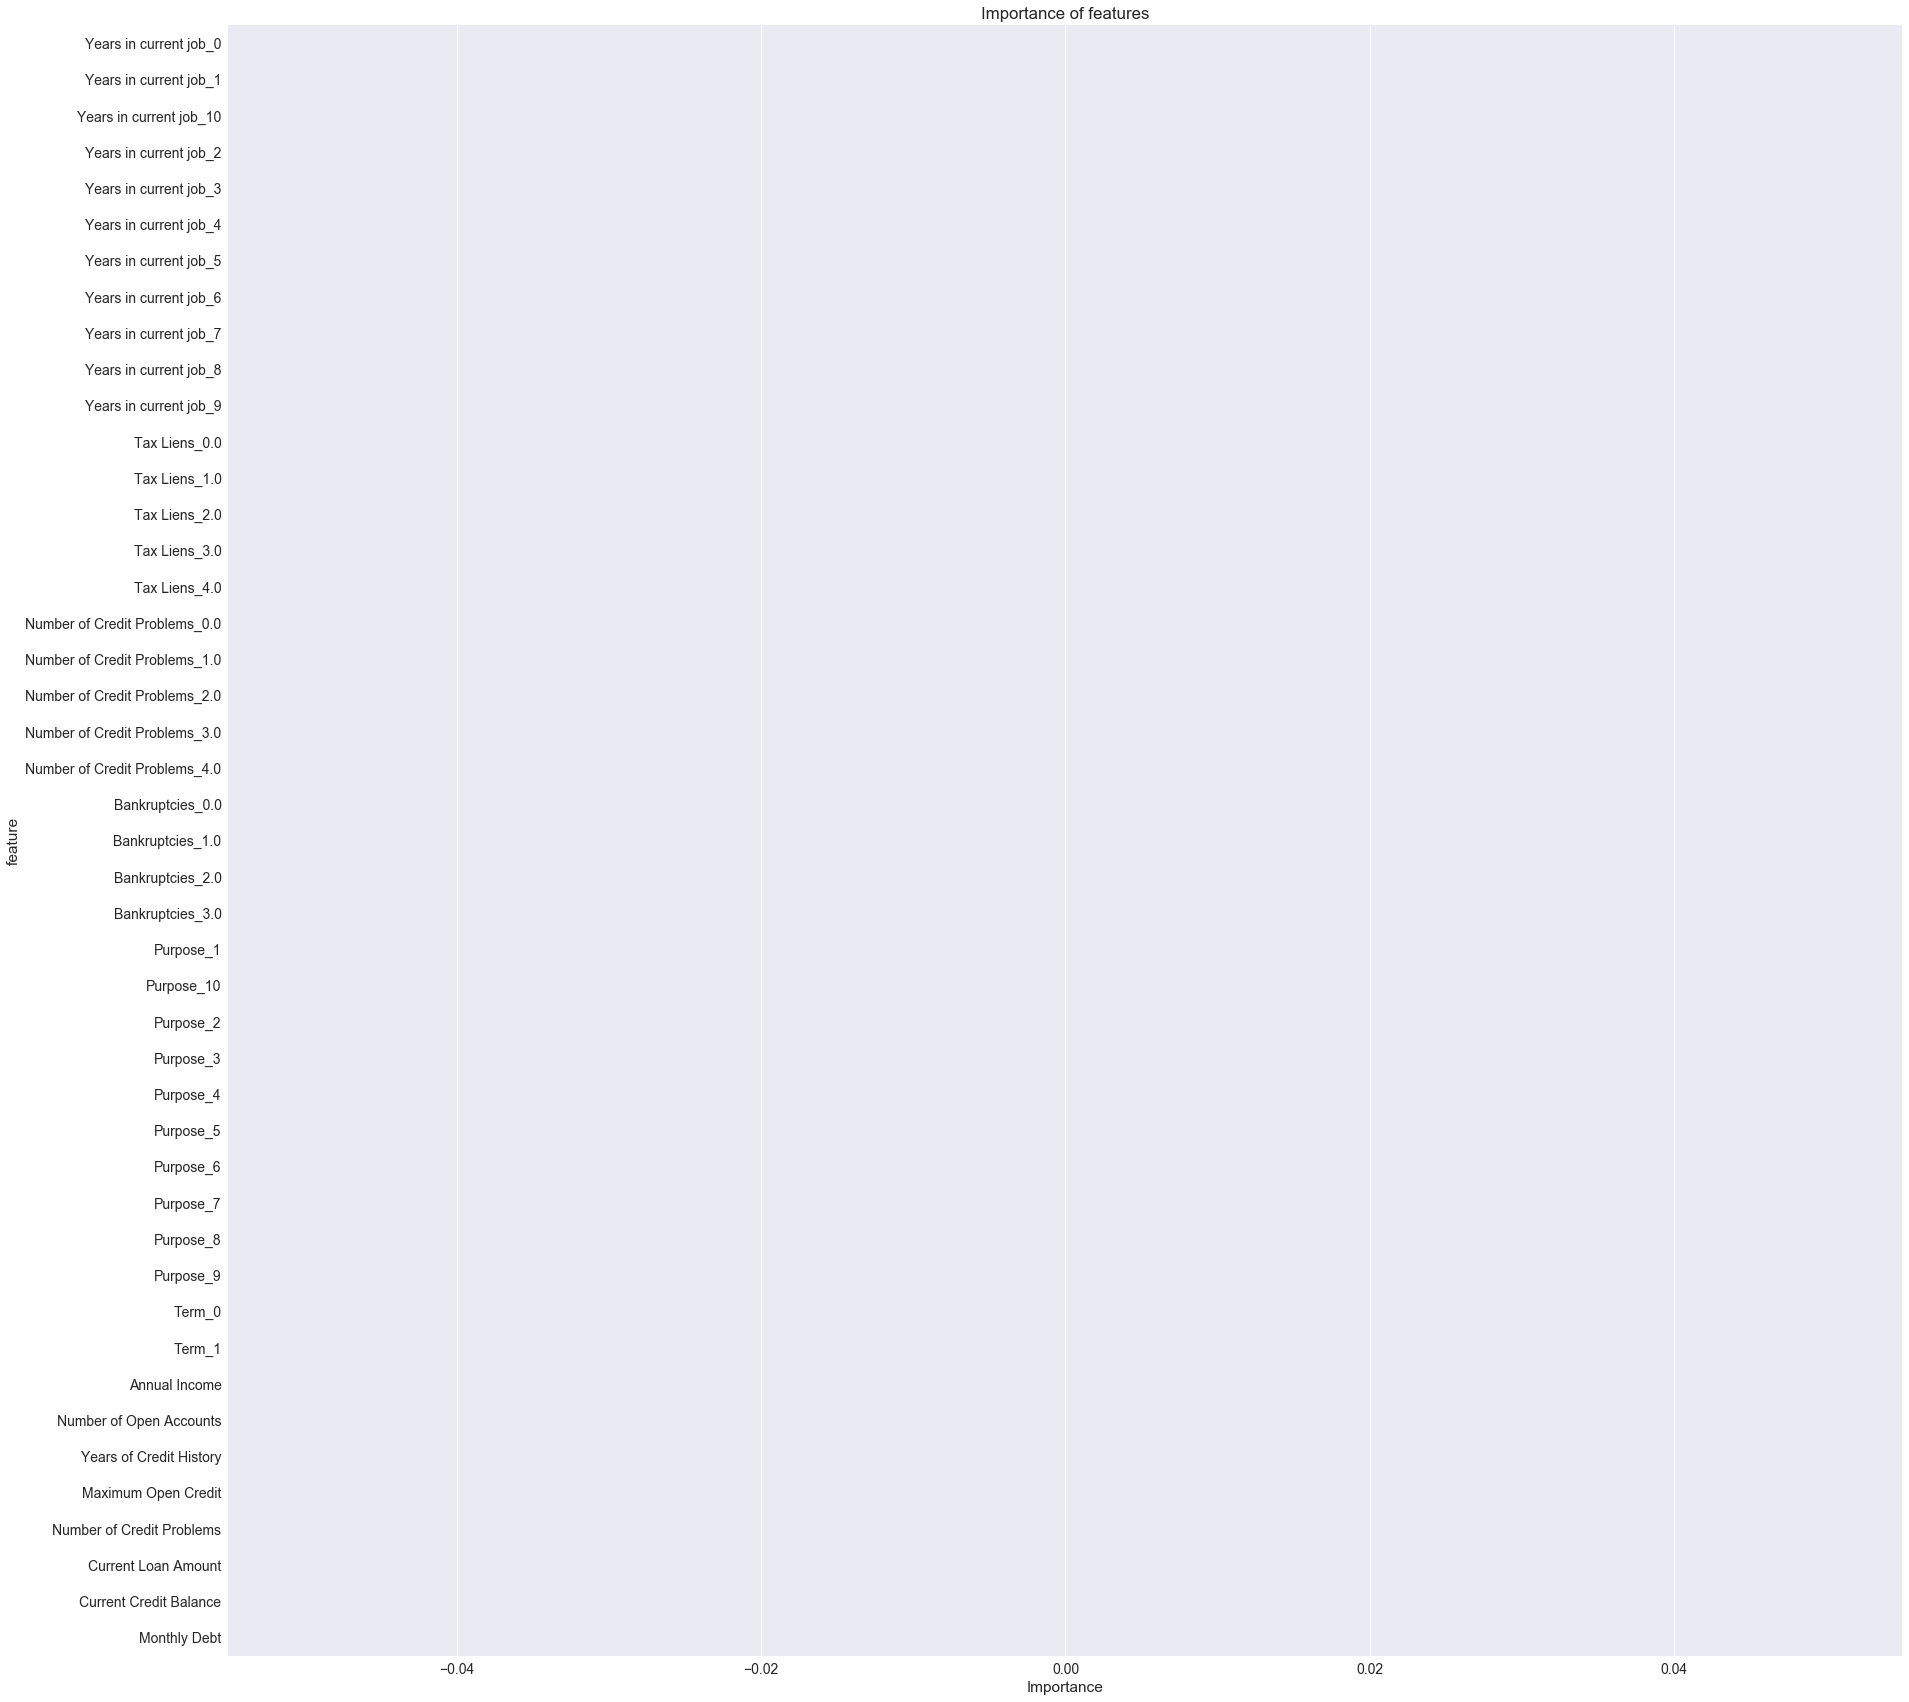

In [88]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_)

In [90]:
important_features_top

### Финальная модель<a class="anchor" id="final_model"></a>

In [90]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2867
           1       0.70      0.67      0.69      2726

    accuracy                           0.70      5593
   macro avg       0.70      0.70      0.70      5593
weighted avg       0.70      0.70      0.70      5593

TEST

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1205
           1       0.45      0.52      0.48       608

    accuracy                           0.63      1813
   macro avg       0.60      0.60      0.60      1813
weighted avg       0.64      0.63      0.64      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               828  377
1               294  314


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [91]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)